# Train a CNN

In [25]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
import seaborn as sns
import pickle
from src.score import *
from collections import OrderedDict

/home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.

In [2]:
def limit_mem():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    tf.Session(config=config)

In [3]:
limit_mem()

In [4]:
sns.set_style('darkgrid')
sns.set_context('notebook')

In [5]:
# DATADIR = '/mnt/netdisk1/stephan/5.625deg/'
DATADIR = '/data/weather-benchmark/5.625deg/'

## Create data generator

In [6]:
# Load the validation subset of the data: 2017 and 2018
z500_valid = load_test_data(f'{DATADIR}geopotential_500', 'z')
t850_valid = load_test_data(f'{DATADIR}temperature_850', 't')
valid = xr.merge([z500_valid, t850_valid])

In [7]:
z = xr.open_mfdataset(f'{DATADIR}geopotential_500/*.nc', combine='by_coords')
t = xr.open_mfdataset(f'{DATADIR}temperature_850/*.nc', combine='by_coords')

In [8]:
datasets = [z, t]
ds = xr.merge(datasets)

In [9]:
ds_train = ds.sel(time=slice('2015', '2016'))
ds_test = ds.sel(time=slice('2017', '2018'))

In [10]:
class DataGenerator(keras.utils.Sequence):
    """https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly"""
    def __init__(self, ds, var_dict, lead_time, batch_size=32, shuffle=True, load=True, mean=None, std=None):
        
        self.ds = ds
        self.var_dict = var_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.lead_time = lead_time
        
        data = []
        generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
        for var, levels in var_dict.items():
            try:
                data.append(ds[var].sel(level=levels))
            except ValueError:
                data.append(ds[var].expand_dims({'level': generic_level}, 1))

        self.data = xr.concat(data, 'level').transpose('time', 'lat', 'lon', 'level')
        self.mean = self.data.mean(('time', 'lat', 'lon')).compute() if mean is None else mean
        self.std = self.data.std('time').mean(('lat', 'lon')).compute() if std is None else std
        # Normalize
        self.data = (self.data - self.mean) / self.std
        self.n_samples = self.data.isel(time=slice(0, -lead_time)).shape[0]
        self.valid_time = self.data.isel(time=slice(lead_time, None)).time
        
        self.on_epoch_end()
        
        if load: print('Loading data into RAM'); self.data.load()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.n_samples / self.batch_size))
    
    def __getitem__(self, i):
        'Generate one batch of data'
        idxs = self.idxs[i*self.batch_size:(i+1)*self.batch_size]
        X = self.data.isel(time=idxs).values
        y = self.data.isel(time=idxs+self.lead_time).values
        return X, y
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.idxs = np.arange(self.n_samples)
        if self.shuffle == True:
            np.random.shuffle(self.idxs)

In [19]:
dic = OrderedDict({'z': None, 't': None})

In [20]:
bs=32
lead_time=6

In [21]:
%%time
dg_train = DataGenerator(ds_train.sel(time=slice('2015', '2015')), dic, lead_time, batch_size=bs, load=True)
dg_valid = DataGenerator(ds_train.sel(time=slice('2016', '2016')), dic, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)

Loading data into RAM
Loading data into RAM
CPU times: user 3.73 s, sys: 3.28 s, total: 7.01 s
Wall time: 784 ms


In [22]:
dg_train.mean, dg_train.std

(<xarray.DataArray 'z' (level: 2)>
 array([54124.863,   274.798], dtype=float32)
 Coordinates:
   * level    (level) int64 850 850, <xarray.DataArray 'z' (level: 2)>
 array([1110.1985   ,    5.6419535], dtype=float32)
 Coordinates:
   * level    (level) int64 850 850)

In [23]:
dg_test = DataGenerator(ds_test, dic, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)

Loading data into RAM


## Create model class

In [24]:
class PeriodicConv2D(tf.keras.layers.Conv2D):
    """Convolution with periodic padding in second spatial dimension (lon)"""
    def __init__(self, filters, kernel_size, **kwargs):
        assert type(kernel_size) is int, 'Periodic convolutions only works for square kernels.'
        self.pad_width = (kernel_size - 1) // 2
        super().__init__(filters, kernel_size, **kwargs)
        assert self.padding == 'valid', 'Periodic convolution only works for valid padding.'
        assert sum(self.strides) == 2, 'Periodic padding only works for stride (1, 1)'
    
    def _pad(self, inputs):
        # Input: [samples, lat, lon, filters]
        # Periodic padding in lon direction
        inputs_padded = tf.concat(
            [inputs[:, :, -self.pad_width:, :], inputs, inputs[:, :, :self.pad_width, :]], axis=2)
        # Zero padding in the lat direction
        inputs_padded = tf.pad(inputs_padded, [[0, 0], [self.pad_width, self.pad_width], [0, 0], [0, 0]])
        return inputs_padded

    def __call__(self, inputs, *args, **kwargs):
        # Unfortunate workaround necessary for TF < 1.13
        inputs_padded = Lambda(self._pad)(inputs)
        return super().__call__(inputs_padded, *args, **kwargs)

In [25]:
def build_cnn(filters, kernels, input_shape, activation='elu', dr=0):
    """Fully convolutional network"""
    x = input = Input(shape=input_shape)
    for f, k in zip(filters[:-1], kernels[:-1]):
        x = PeriodicConv2D(f, k, activation=activation)(x)
        if dr > 0: x = Dropout(dr)(x)
    output = PeriodicConv2D(filters[-1], kernels[-1])(x)
    return keras.models.Model(input, output)

In [26]:
cnn = build_cnn([32, 64, 64, 64, 2], [5, 5, 5, 5, 5], (32, 64, 2))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [27]:
cnn.compile(keras.optimizers.Adam(1e-4), 'mse')

In [28]:
cnn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 64, 2)]       0         
_________________________________________________________________
lambda (Lambda)              (None, 36, 68, 2)         0         
_________________________________________________________________
periodic_conv2d (PeriodicCon (None, 32, 64, 32)        1632      
_________________________________________________________________
lambda_1 (Lambda)            (None, 36, 68, 32)        0         
_________________________________________________________________
periodic_conv2d_1 (PeriodicC (None, 32, 64, 64)        51264     
_________________________________________________________________
lambda_2 (Lambda)            (None, 36, 68, 64)        0         
_________________________________________________________________
periodic_conv2d_2 (PeriodicC (None, 32, 64, 64)        102464

In [29]:
cnn.fit_generator(dg_train, epochs=100, validation_data=dg_valid, 
                  callbacks=[tf.keras.callbacks.EarlyStopping(
                                monitor='val_loss',
                                min_delta=0,
                                patience=2,
                                verbose=1, 
                                mode='auto'
                            )]
                 )

Epoch 1/100
274/274 [==============================] - 13s 47ms/step - loss: 0.3964 - val_loss: 0.0900
Epoch 2/100
274/274 [==============================] - 10s 36ms/step - loss: 0.0726 - val_loss: 0.0636
Epoch 3/100
274/274 [==============================] - 10s 38ms/step - loss: 0.0586 - val_loss: 0.0559
Epoch 4/100
274/274 [==============================] - 10s 37ms/step - loss: 0.0533 - val_loss: 0.0526
Epoch 5/100
274/274 [==============================] - 10s 36ms/step - loss: 0.0504 - val_loss: 0.0500
Epoch 6/100
274/274 [==============================] - 10s 36ms/step - loss: 0.0486 - val_loss: 0.0481
Epoch 7/100
274/274 [==============================] - 10s 36ms/step - loss: 0.0471 - val_loss: 0.0477
Epoch 8/100
274/274 [==============================] - 10s 37ms/step - loss: 0.0461 - val_loss: 0.0461
Epoch 9/100
274/274 [==============================] - 10s 37ms/step - loss: 0.0452 - val_loss: 0.0453
Epoch 10/100
274/274 [==============================] - 10s 35ms/step - l

In [30]:
# cnn.save_weights('/home/rasp/cube_home/tmp/test.h5')

In [32]:
def create_predictions(model, dg):
    """Create predictions for non-iterative model"""
    preds = model.predict_generator(dg)
    # Unnormalize
    preds = preds * dg.std.values + dg.mean.values
    fcs = []
    lev_idx = 0
    for var, levels in dg.var_dict.items():
        if levels is None:
            fcs.append(xr.DataArray(
                preds[:, :, :, lev_idx],
                dims=['time', 'lat', 'lon'],
                coords={'time': dg.valid_time, 'lat': dg.ds.lat, 'lon': dg.ds.lon},
                name=var
            ))
            lev_idx += 1
        else:
            nlevs = len(levels)
            fcs.append(xr.DataArray(
                preds[:, :, :, lev_idx:lev_idx+nlevs],
                dims=['time', 'lat', 'lon', 'level'],
                coords={'time': dg.valid_time, 'lat': dg.ds.lat, 'lon': dg.ds.lon, 'level': levels},
                name=var
            ))
            lev_idx += nlevs
    return xr.merge(fcs)

In [33]:
fc = create_predictions(cnn, dg_test)

In [34]:
compute_weighted_rmse(fc, valid).compute()

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    level    int32 850
Data variables:
    z_rmse   float64 153.3
    t_rmse   float64 1.296

In [66]:
def create_iterative_predictions(model, dg, max_lead_time=5*24):
    state = dg.data[:dg.n_samples]
    preds = []
    for _ in range(max_lead_time // dg.lead_time):
        state = model.predict(state)
        p = state * dg.std.values + dg.mean.values
        preds.append(p)
    preds = np.array(preds)
    
    lead_time = np.arange(dg.lead_time, max_lead_time + dg.lead_time, dg.lead_time)
    das = []; lev_idx = 0
    for var, levels in dg.var_dict.items():
        if levels is None:
            das.append(xr.DataArray(
                preds[:, :, :, :, lev_idx],
                dims=['lead_time', 'time', 'lat', 'lon'],
                coords={'lead_time': lead_time, 'time': dg.valid_time, 'lat': dg.ds.lat, 'lon': dg.ds.lon},
                name=var
            ))
            lev_idx += 1
        else:
            nlevs = len(levels)
            das.append(xr.DataArray(
                preds[:, :, :, :, lev_idx:lev_idx+nlevs],
                dims=['lead_time', 'time', 'lat', 'lon', 'level'],
                coords={'lead_time': lead_time, 'time': dg.valid_time, 'lat': dg.ds.lat, 'lon': dg.ds.lon, 'level': levels},
                name=var
            ))
            lev_idx += nlevs
    return xr.merge(das)

In [67]:
fc = create_iterative_predictions(cnn, dg_test)

In [68]:
rmse = evaluate_iterative_forecast(fc, valid)

In [69]:
rmse.load()

<xarray.Dataset>
Dimensions:    (lead_time: 20)
Coordinates:
    level      int32 850
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120
Data variables:
    z_rmse     (lead_time) float64 266.9 333.5 393.1 ... 1.229e+03 1.271e+03
    t_rmse     (lead_time) float64 1.886 2.052 2.219 2.507 ... 4.917 5.035 5.159

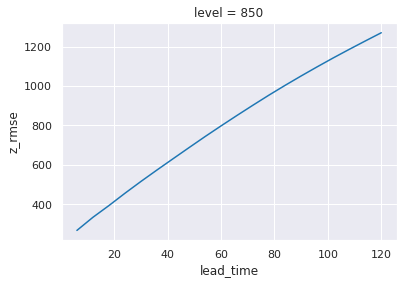

In [62]:
rmse.z_rmse.plot()

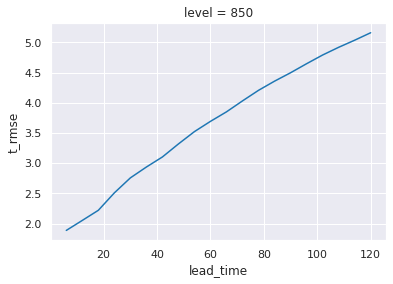

In [63]:
rmse.t_rmse.plot()